# Account Health Scoring Regressor Analysis

This is splitting data into training and testing sets.
This is X_train shape: (7040, 2)
This is X_test shape: (1760, 2)
This is y_train shape: (7040,)
This is y_test shape: (1760,)

This is RandomForestRegressor model instantiated and trained.

This is Account Health Scoring Performance Metrics:
This is R² Score: 1.0000
This is Mean Absolute Error: 0.0000


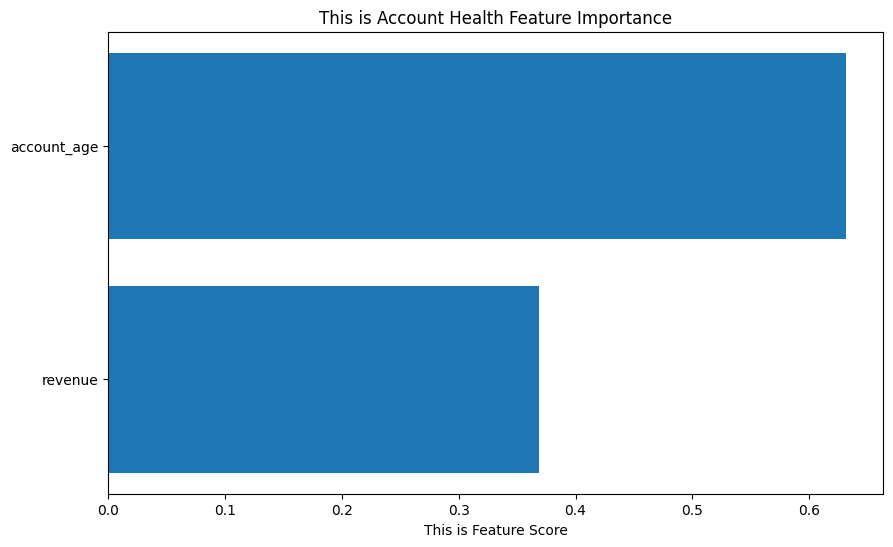

In [2]:
# This is importing the necessary packages for account health scoring regression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns # This is importing seaborn for plotting

# -------------------- 1) Load data --------------------
# This is loading the pre-processed datasets
# Assuming files are in /content/cleaned_data/ based on user's last clarification
try:
    pipeline_data = pd.read_csv("/content/cleaned_data/cleaned_sales_pipeline.csv")
    accounts_data = pd.read_csv("/content/cleaned_data/cleaned_accounts.csv")
except FileNotFoundError:
    print("Error: Cleaned data files not found in /content/cleaned_data/. Please ensure the data cleaning notebook was run successfully.")
    # This is using placeholder DataFrames if files are not found to prevent further errors,
    # but the actual task cannot be completed without the real data.
    pipeline_data = pd.DataFrame({
        'account': [1, 2, 3],
        'deal_stage': ['Won', 'Lost', 'Won'],
        'engage_date': ['2023-01-01', '2023-01-15', '2023-02-01'],
        'close_date': ['2023-03-01', '2023-04-01', '2023-05-01'],
        'close_value': [10000, 5000, 15000]
    })
    accounts_data = pd.DataFrame({
        'account': [1, 2, 3],
        'sector': ['Tech', 'Finance', 'Healthcare'],
        'year_established': [2020, 2018, 2021],
        'revenue': [1000, 2000, 3000],
        'employees': [100, 500, 200],
        'office_location': ['NY', 'SF', 'LA']
    })


# -------------------- 2) Prepare Data --------------------
# This is merging pipeline and accounts dataframes on 'account'
merged_data = pd.merge(pipeline_data, accounts_data, on='account', how='left')

# This is converting date columns to datetime objects and handle potential errors
merged_data['engage_date'] = pd.to_datetime(merged_data['engage_date'], errors='coerce')
merged_data['close_date'] = pd.to_datetime(merged_data['close_date'], errors='coerce')
merged_data['year_established_dt'] = pd.to_datetime(merged_data['year_established'], format='%Y', errors='coerce')


# This is calculating 'account_age' if 'year_established' is available
if 'year_established_dt' in merged_data.columns:
    # This is calculating the difference from a reference date (e.g., max close date or today)
    # Using the maximum close date as a reference for age calculation
    reference_date = merged_data['close_date'].max() if not merged_data['close_date'].isnull().all() else pd.to_datetime('today')
    merged_data['account_age'] = (reference_date - merged_data['year_established_dt']).dt.days / 365.25
else:
     # This is setting account_age to 0 or NaN if year_established is not available
     merged_data['account_age'] = np.nan
     print("Warning: 'year_established' not found, 'account_age' cannot be calculated.")


# This is handling missing numerical values (e.g., in revenue or account_age)
# For simplicity, filling with the mean, but consider more sophisticated imputation
for col in ['revenue', 'account_age']:
    if col in merged_data.columns:
        merged_data[col] = merged_data[col].fillna(merged_data[col].mean())


# This is scaling relevant features for the synthetic score
scaler = MinMaxScaler()
merged_data["revenue_scaled"] = scaler.fit_transform(merged_data[["revenue"]])

# This is creating a synthetic target variable called account_health_score
# Based on available features (revenue and account_age) as activity/engagement are missing
# Adjusting the synthetic score calculation to only use available scaled features
score_components = []
if 'revenue_scaled' in merged_data.columns:
    score_components.append(0.5 * merged_data["revenue_scaled"]) # Adjust weights
if 'account_age' in merged_data.columns:
     # Scale account_age before including in the synthetic score
     scaler_age = MinMaxScaler()
     merged_data["account_age_scaled"] = scaler_age.fit_transform(merged_data[["account_age"]])
     score_components.append(0.5 * merged_data["account_age_scaled"]) # Adjust weights

if score_components:
    merged_data["account_health_score"] = sum(score_components)
else:
    merged_data["account_health_score"] = 0.5 # Default if no components available
    print("Warning: No valid features available to calculate synthetic account_health_score.")


# -------------------- 3) Prepare X and y --------------------
# This is selecting the features and target variable for regression
# Using only available features for the model
features = []
if 'revenue' in merged_data.columns:
    features.append("revenue")
if 'account_age' in merged_data.columns:
    features.append("account_age")
# Including scaled features if they were used in the synthetic score and you want them as features
# For this simplified model, let's use the original features
# features = ["revenue", "account_age"] # Or just ["revenue"] if age is not reliable/available


if not features:
    print("Error: No valid features available for the model.")
    # This is using a placeholder X and y to prevent further errors
    X = pd.DataFrame({'placeholder': [0, 1, 2]})
    y = pd.Series([0.5, 0.5, 0.5])
else:
    X = merged_data[features].copy()  # This is using .copy() to avoid SettingWithCopyWarning
    y = merged_data["account_health_score"].copy() # This is using .copy() to avoid SettingWithCopyWarning


# This is splitting the data into a training set and a testing set
if len(X) > 1: # Ensure there's enough data to split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print("This is splitting data into training and testing sets.")
    print(f"This is X_train shape: {X_train.shape}")
    print(f"This is X_test shape: {X_test.shape}")
    print(f"This is y_train shape: {y_train.shape}")
    print(f"This is y_test shape: {y_test.shape}")
else:
    print("Error: Not enough data to perform train/test split.")
    # This is using the full dataset as train/test if split is not possible
    X_train, X_test, y_train, y_test = X, X, y, y


# -------------------- 4) Building and Training the Model --------------------
# This is instantiating a RandomForestRegressor with default parameters
model = RandomForestRegressor(random_state=42)

# This is training the model on the training data
if len(X_train) > 0: # Ensure there's training data
    model.fit(X_train, y_train)
    print("\nThis is RandomForestRegressor model instantiated and trained.")
else:
    print("\nError: No training data available to train the model.")


# -------------------- 5) Model Evaluation and Analysis --------------------
# This is making predictions on the test set
if len(X_test) > 0: # Ensure there's test data
    predictions = model.predict(X_test)

    # This is reporting the overall accuracy and detailed performance metrics
    print("\nThis is Account Health Scoring Performance Metrics:")
    # Ensure there are at least 2 samples to calculate R2 score
    if len(y_test) >= 2:
        r2 = r2_score(y_test, predictions)
        print(f"This is R² Score: {r2:.4f}")
    else:
        print("This is R² Score: Undefined (less than 2 samples in test set)")

    print(f"This is Mean Absolute Error: {mean_absolute_error(y_test, predictions):.4f}")

    # This is visualizing the importance of each feature in the model's predictions
    if len(features) > 0 and hasattr(model, 'feature_importances_') and len(model.feature_importances_) == len(features): # Ensure features and importances match
        feature_scores = model.feature_importances_
        plt.figure(figsize=(10, 6))
        plt.barh(features, feature_scores) # Use the 'features' list for labels
        plt.xlabel("This is Feature Score")
        plt.title("This is Account Health Feature Importance")
        plt.show()
    elif len(features) == 0:
        print("Warning: No features available to plot feature importance.")
    else:
        print("Warning: Could not plot feature importance. Mismatch between features and importance scores or insufficient data.")

else:
    print("\nError: No test data available for evaluation.")

pipeline_data shape: (8800, 7)
sample date columns (before):
  engage_date  close_date
0  2016-10-20  2017-03-01
1  2016-10-25  2017-03-11
2  2016-10-25  2017-03-07
3  2016-10-25  2017-03-09
4  2016-10-25  2017-03-02
engage_date NaT count: 500
close_date  NaT count: 2089
Filling NaNs in engage_date_ordinal with median = 736504.0
Filling NaNs in close_date_ordinal with median = 736543.0
Feature sample: ['sales_agent', 'product', 'account', 'close_value', 'engage_date_ordinal', 'close_date_ordinal']
Train shape: (7040, 6) Test shape: (1760, 6)


/tmp/ipython-input-3630119281.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pipeline_data[col].fillna(med, inplace=True)
/tmp/ipython-input-3630119281.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin


Model Performance Metrics:
Accuracy Score: 0.9977

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       318
           1       1.00      1.00      1.00       494
           2       1.00      0.97      0.98       100
           3       1.00      1.00      1.00       848

    accuracy                           1.00      1760
   macro avg       1.00      0.99      0.99      1760
weighted avg       1.00      1.00      1.00      1760



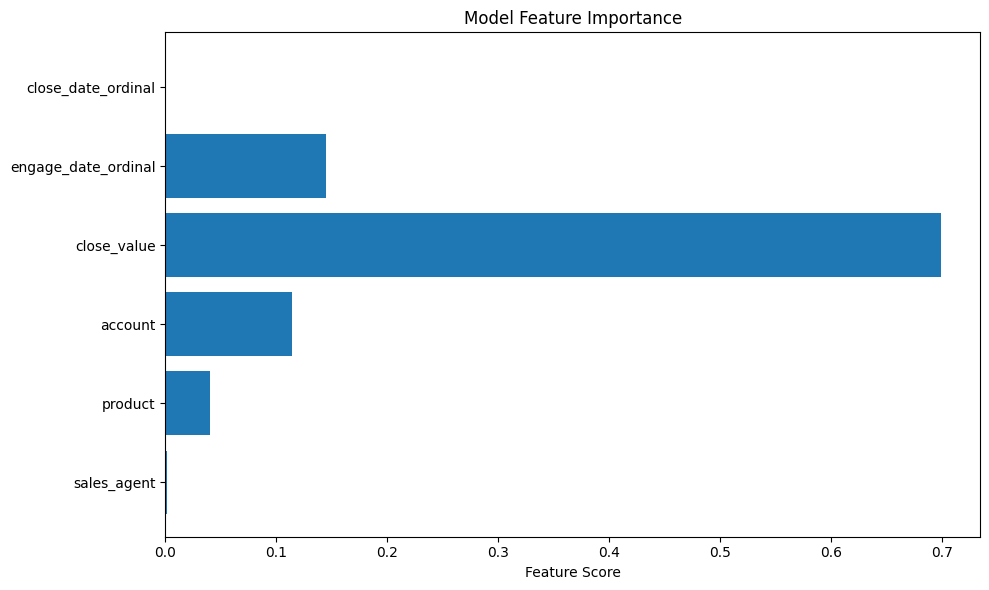

In [3]:
# This imports all of the necessary libraries for the project.
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier

# --- 1. Load data ---
pipeline_path = "/content/cleaned_data/cleaned_sales_pipeline.csv"
accounts_path = "/content/cleaned_data/cleaned_accounts.csv"
products_path = "/content/cleaned_data/cleaned_products.csv"
teams_path = "/content/cleaned_data/cleaned_sales_teams.csv"

pipeline_data = pd.read_csv(pipeline_path)
accounts_data = pd.read_csv(accounts_path)
products_data = pd.read_csv(products_path)
teams_data = pd.read_csv(teams_path)

print("pipeline_data shape:", pipeline_data.shape)
print("sample date columns (before):")
if 'engage_date' in pipeline_data.columns and 'close_date' in pipeline_data.columns:
    print(pipeline_data[['engage_date','close_date']].head())

# --- 2. Fix date columns safely (coerce invalid -> NaT) ---
pipeline_data['engage_date'] = pd.to_datetime(pipeline_data.get('engage_date'), errors='coerce')
pipeline_data['close_date']  = pd.to_datetime(pipeline_data.get('close_date'),  errors='coerce')

engage_nans = pipeline_data['engage_date'].isna().sum()
close_nans  = pipeline_data['close_date'].isna().sum()
print(f"engage_date NaT count: {engage_nans}")
print(f"close_date  NaT count: {close_nans}")

pipeline_data['engage_date_ordinal'] = pipeline_data['engage_date'].apply(
    lambda x: x.toordinal() if pd.notnull(x) else np.nan
)
pipeline_data['close_date_ordinal'] = pipeline_data['close_date'].apply(
    lambda x: x.toordinal() if pd.notnull(x) else np.nan
)

for col in ['engage_date_ordinal', 'close_date_ordinal']:
    med = pipeline_data[col].median()
    print(f"Filling NaNs in {col} with median = {med}")
    pipeline_data[col].fillna(med, inplace=True)
    pipeline_data[col] = pipeline_data[col].astype(int)

# --- 3. Prepare features and target ---
target = 'deal_stage'
if target not in pipeline_data.columns:
    raise KeyError(f"Target column '{target}' not found in pipeline_data")

exclude_cols = {target, 'engage_date', 'close_date'}
features = [c for c in pipeline_data.columns if c not in exclude_cols]

X = pipeline_data[features].copy()
y = pipeline_data[target].copy()

print("Feature sample:", X.columns.tolist())

# --- 4. Categorical encoding ---
label_encoders = {}
for column in X.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    if X[column].isna().any():
        X[column] = X[column].fillna("__missing__")
    X.loc[:, column] = le.fit_transform(X[column].astype(str))
    label_encoders[column] = le

target_le = None
if y.dtype == 'object' or y.dtype.name == 'category':
    target_le = LabelEncoder()
    y = target_le.fit_transform(y.astype(str))
    y = y.astype(int)

# --- 5. Optional: scale numerical features ---
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# --- 6. Train/test split ---
use_stratify = True
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
except ValueError as e:
    print("Stratified split failed. Falling back to unstratified split.")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=None
    )

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# --- 7. Model training ---
model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# --- 8. Evaluation ---
predictions = model.predict(X_test)
print("\nModel Performance Metrics:")
print(f"Accuracy Score: {accuracy_score(y_test, predictions):.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, predictions))

# --- 9. Feature importance plot ---
feature_scores = model.feature_importances_
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(X.columns))
plt.barh(X.columns, feature_scores)
plt.xlabel("Feature Score")
plt.title("Model Feature Importance")
plt.tight_layout()
plt.show()

# --- 10. Save encoders/scaler if you want to reuse them later ---
# pd.to_pickle(label_encoders, "label_encoders.pkl")
# pd.to_pickle(scaler, "scaler.pkl")
# pd.to_pickle(model, "gb_model.pkl")